In [245]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import numpy as np
import tensorflow
import spektral
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from spektral.data import Dataset, BatchLoader, Graph
from spektral.transforms.normalize_adj import NormalizeAdj
from tensorflow.keras.layers import Dropout
from spektral.layers import GCNConv, GlobalSumPool, GCSConv, GlobalAvgPool

In [246]:

df = pd.read_csv('train.csv', header=[0, 1])
test_raw = pd.read_csv('test.csv', header=[0, 1])
meta_df = pd.read_csv("metaData.csv")
#get target feature out of df
target = df[['Timestamp',"target_feature"]].rename(columns={"Unnamed: 1_level_1":"","Unnamed: 53_level_1":""})
target.columns = [''.join(col).strip() for col in target.columns] 
target.drop(target.iloc[0].name, inplace=True)
target["Timestamp"] = pd.to_datetime(target["Timestamp"])

df.head()

C:\Users\conny\AppData\Local\Temp\ipykernel_17312\1202832811.py:1: DtypeWarning: Columns (0,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv', header=[0, 1])
C:\Users\conny\AppData\Local\Temp\ipykernel_17312\1202832811.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_raw = pd.read_csv('test.csv', header=[0, 1])


Unnamed: 0_level_0            Timestamp Wind speed (m/s)             \
             Turbine   Unnamed: 1_level_1       Kelmarsh 2 Kelmarsh 3   
0                 id                  NaN              NaN        NaN   
1                  0  2017-10-01 00:00:00         9.112875   9.197829   
2                  1  2017-10-01 00:10:00         8.319863   9.350296   
3                  2  2017-10-01 00:20:00         8.799176   8.510402   
4                  3  2017-10-01 00:30:00         8.392921   8.825861   

                                   Wind speed, Standard deviation (m/s)  \
  Kelmarsh 4 Kelmarsh 5 Kelmarsh 6                           Kelmarsh 2   
0        NaN        NaN        NaN                                  NaN   
1   8.795919   8.749384   7.684954                             1.104222   
2   8.762059   8.652318   7.421576                             1.207655   
3   9.533566   8.166586   7.797040                             1.124029   
4   8.990985   7.877046   7.750090                             1.219647   

                         ... Generator RPM (RPM)                            \
  Kelmarsh 3 Kelmarsh 4  ...          Kelmarsh 4   Kelmarsh 5   Kelmarsh 6   
0        NaN        NaN  ...                 NaN          NaN          NaN   
1   1.096619   0.999588  ...         1768.215088  1733.296875  1603.749390   
2   0.916610   0.956899  ...         1770.806885  1737.218262  1572.769409   
3   0.992841   1.343180  ...         1766.002319  1698.699219  1655.049316   
4   1.218454   0.970566  ...         1783.569824  1661.264526  1678.571777   

  Blade angle (pitch position) A (°)                                   \
                          Kelmarsh 2 Kelmarsh 3 Kelmarsh 4 Kelmarsh 5   
0                                NaN        NaN        NaN        NaN   
1                           0.183487   0.135490   0.001053     0.0000   
2                           0.051998   0.086999   0.095998     0.0605   
3                           0.168988   0.056997   0.087998     0.0090   
4                           0.084492   0.133995   0.017500     0.0000   

                        training      target_feature  
  Kelmarsh 6 Unnamed: 52_level_1 Unnamed: 53_level_1  
0        NaN                 NaN                 NaN  
1      0.000                True            8.602844  
2      0.000                True            8.125226  
3      0.016                True            7.551986  
4      0.000                True            7.912114  

[5 rows x 54 columns]

In [247]:
df.columns

MultiIndex([(                      'Unnamed: 0_level_0', ...),
            (                               'Timestamp', ...),
            (                        'Wind speed (m/s)', ...),
            (                        'Wind speed (m/s)', ...),
            (                        'Wind speed (m/s)', ...),
            (                        'Wind speed (m/s)', ...),
            (                        'Wind speed (m/s)', ...),
            (    'Wind speed, Standard deviation (m/s)', ...),
            (    'Wind speed, Standard deviation (m/s)', ...),
            (    'Wind speed, Standard deviation (m/s)', ...),
            (    'Wind speed, Standard deviation (m/s)', ...),
            (    'Wind speed, Standard deviation (m/s)', ...),
            (                      'Wind direction (°)', ...),
            (                      'Wind direction (°)', ...),
            (                      'Wind direction (°)', ...),
            (                      'Wind direction (°)'

In [248]:
df.columns = ['_'.join(col).strip() for col in df.columns]  # Flatten multi-index
#df = df[(df['Wind direction (°)_Kelmarsh 2']>45)&(df['Wind direction (°)_Kelmarsh 2']<135) ]
df.rename(columns={"Timestamp_Unnamed: 1_level_1": "Timestamp"}, inplace=True)  # Rename timestamp
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df= df[~df["target_feature_Unnamed: 53_level_1"].isna()]
target = target[~target["target_feature"].isna()]
test_raw.columns = ['_'.join(col).strip() for col in test_raw.columns]  # Flatten multi-index
test_raw.rename(columns={"Timestamp_Unnamed: 1_level_1": "Timestamp"}, inplace=True)  # Rename timestamp
test_raw["Timestamp"] = pd.to_datetime(test_raw["Timestamp"])

In [249]:
df_long = df.melt(id_vars=["Timestamp"], 
                  var_name="Variable_Turbine", 
                  value_name="Value")

# Split 'Variable_Turbine' into 'Variable' and 'Turbine'
df_long[["Variable", "Turbine"]] = df_long["Variable_Turbine"].str.rsplit("_", n=1, expand=True)
df_long.drop(columns=["Variable_Turbine"], inplace=True)
df_long=df_long[df_long["Turbine"].str.contains("Kelmarsh")]
df_long.head()  # View the reshaped dataframedf
test_long = test_raw.melt(id_vars=["Timestamp"], 
                  var_name="Variable_Turbine", 
                  value_name="Value")

# Split 'Variable_Turbine' into 'Variable' and 'Turbine'
test_long[["Variable", "Turbine"]] = test_long["Variable_Turbine"].str.rsplit("_", n=1, expand=True)
test_long.drop(columns=["Variable_Turbine"], inplace=True)
test_long=test_long[test_long["Turbine"].str.contains("Kelmarsh")]

In [250]:
df_wide = df_long.pivot(index=['Timestamp', 'Turbine'], columns='Variable', values='Value').reset_index()
df_wide = df_wide[df_wide["Timestamp"].notna()]
df_wide = df_wide.fillna(0)
test_wide = test_long.pivot(index=['Timestamp', 'Turbine'], columns='Variable', values='Value').reset_index()
test_wide = test_wide[test_wide["Timestamp"].notna()]
test_wide = test_wide.fillna(0)

C:\Users\conny\AppData\Local\Temp\ipykernel_17312\1922771118.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_wide = df_wide.fillna(0)
C:\Users\conny\AppData\Local\Temp\ipykernel_17312\1922771118.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_wide = test_wide.fillna(0)


In [251]:
test_wide.Timestamp.unique()

<DatetimeArray>
['2017-10-15 00:00:00', '2017-10-15 00:10:00', '2017-10-15 00:20:00',
 '2017-10-15 00:30:00', '2017-10-15 00:40:00', '2017-10-15 00:50:00',
 '2017-10-15 01:00:00', '2017-10-15 01:10:00', '2017-10-15 01:20:00',
 '2017-10-15 01:30:00',
 ...
 '2021-06-05 22:20:00', '2021-06-05 22:30:00', '2021-06-05 22:40:00',
 '2021-06-05 22:50:00', '2021-06-05 23:00:00', '2021-06-05 23:10:00',
 '2021-06-05 23:20:00', '2021-06-05 23:30:00', '2021-06-05 23:40:00',
 '2021-06-05 23:50:00']
Length: 64512, dtype: datetime64[ns]

In [252]:
meta_df["total_hub_height"] = meta_df["Hub Height (m)"]  + meta_df["Elevation (m)"] 

In [253]:
#df_wide_meta = df_wide.merge(meta_df, left_on="Turbine",right_on="Title")

In [254]:
df_final = df_wide.merge(target, on="Timestamp")

In [255]:
df_final.columns

Index(['Timestamp', 'Turbine', 'Blade angle (pitch position) A (°)',
       'Generator RPM (RPM)', 'Nacelle ambient temperature (°C)',
       'Nacelle position (°)', 'Nacelle position, Standard deviation (°)',
       'Power (kW)', 'Vane position 1+2 (°)', 'Wind direction (°)',
       'Wind speed (m/s)', 'Wind speed, Standard deviation (m/s)',
       'target_feature'],
      dtype='object')

In [256]:
meta_df = meta_df[meta_df.Title != "Kelmarsh 1"]

In [257]:
meta_df

,Wind Farm,Title,Alternative Title,Identity,Manufacturer,Model,Rated power (kW),Hub Height (m),Rotor Diameter (m),Latitude,Longitude,Elevation (m),Country,Commercial Operations Date,total_hub_height
1,Kelmarsh,Kelmarsh 2,KWF2,SEN 93421,Senvion,MM92,2050,78.5,92,52.402551,-0.949527,156.577,UK,15/04/2016,235.077
2,Kelmarsh,Kelmarsh 3,KWF3,SEN 93422,Senvion,MM92,2050,68.5,92,52.403834,-0.944190,153.477,UK,15/04/2016,221.977
3,Kelmarsh,Kelmarsh 4,KWF4,SEN 93423,Senvion,MM92,2050,78.5,92,52.398781,-0.941150,146.313,UK,15/04/2016,224.813
4,Kelmarsh,Kelmarsh 5,KWF5,SEN 93424,Senvion,MM92,2050,78.5,92,52.402308,-0.940537,142.901,UK,15/04/2016,221.401
5,Kelmarsh,Kelmarsh 6,KWF6,SEN 93425,Senvion,MM92,2050,68.5,92,52.400687,-0.936093,135.039,UK,15/04/2016,203.539


In [258]:
#get bearings between turbines
def calculate_bearing_matrix(df):
    """
    Returns a matrix where bearing_matrix[i][j] = angle from turbine i to j.
    """
    lat = df['Latitude'].values
    lon = df['Longitude'].values
    n = len(df)
    bearing_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                lat1, lon1, lat2, lon2 = map(np.radians, [lat[i], lon[i], lat[j], lon[j]])
                dlon = lon2 - lon1
                x = np.sin(dlon) * np.cos(lat2)
                y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
                bearing = np.degrees(np.arctan2(x, y))
                bearing_matrix[i][j] = (bearing + 360) % 360
    return bearing_matrix

In [259]:
calculate_bearing_matrix(meta_df)

array([[  0.        ,  68.49202885, 126.40950146,  92.53317909,
        102.80681547],
       [248.49625748,   0.        , 159.84230795, 124.39809308,
        122.49525874],
       [306.41613853, 339.84471656,   0.        ,   6.05296291,
         58.29339521],
       [272.54030201, 304.40098743, 186.05344859,   0.        ,
        120.87123328],
       [282.81745932, 302.5016741 , 238.2974018 , 300.87475429,
          0.        ]])

In [260]:
def relative_wind_angle(wind_dir, bearing):
    """
    Compute relative wind angle (if turbine is blocked)

    Args:
        wind_dir (column): wind direction variable
        bearing (matrix): matrix of pairwise angles to turbines

    Returns:
        float: angle
        
    """
    wind_impact_dir = (wind_dir + 180) % 360  # Reverse wind direction
    angle_diff = abs(wind_impact_dir - bearing) % 360
    return min(angle_diff, 360 - angle_diff)

In [261]:
def get_turbine_distances(meta_df):
    """
    Compute pairwise distances between turbines.

    Args:
        meta_df (pd.DataFrame): DataFrame containing 'Latitude' and 'Longitude'.

    Returns:
        array: {("Turbine A", "Turbine B"): (distance)}
        
    """
    coords = meta_df[['Latitude', 'Longitude']].values
    
    # Calculate pairwise distances
    dist_matrix = distance_matrix(coords, coords)
    
    return dist_matrix

In [262]:
def wind_dir_to_onehot(angles):
    """
    Robust conversion of wind directions (0-360°) to 8-direction one-hot encoding.
    Handles all edge cases including 0°, 360°, and values at bin boundaries.
    """
    angles = np.array(angles)
    
    # Define direction bins and labels
    #bins = [0, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5, 360]
    #labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    bins = [0, 45, 135, 225, 315]
    labels = ['N', 'E', 'S', 'W']
    # Special handling for 360° (map to North)
    angles = np.where(angles == 360, 0, angles)
    
    # Digitize and adjust indices
    indices = np.digitize(angles, bins, right=False) - 1
    indices = np.where(indices == 8, 0, indices)  # Handle 337.5-360° range
    
    # One-hot encoding
    onehot = pd.DataFrame(0, index=range(len(angles)), columns=labels)
    for i, label in enumerate(labels):
        onehot[label] = (indices == i).astype(int)
    onehot =onehot.fillna(0)
    return onehot


In [263]:
turbine_distances = get_turbine_distances(meta_df)
bearing_matrix = calculate_bearing_matrix(meta_df)

In [264]:
bearing_matrix[1,:]

array([248.49625748,   0.        , 159.84230795, 124.39809308,
       122.49525874])

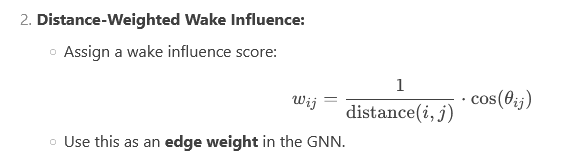

Distance-Weighted Wake Influence:

    Assign a wake influence score:
    wij=1distance(i,j)⋅cos⁡(θij)
    wij​=distance(i,j)1​⋅cos(θij​)

    Use this as an edge weight in the GNN.

In [265]:
def get_woke(df):
    """
    Compute pairwise wake alignment between turbines, will be adjacency matrix for model

    Args:
        meta_df (pd.DataFrame): DataFrame containing 'Latitude' and 'Longitude'.

    Returns:
        array: {("Turbine A", "Turbine B"): (wake alignment)}
        
    """
    adj_matrix = np.empty((5,5))
    
    #for index, row in df.iterrows():
        #print(row)
        #subset_bearing = bearing[index,:]
    for i in range(bearing_matrix.shape[0]):
        for j in range(bearing_matrix.shape[0]):
            #print(bearing_matrix[i,j])
            rel_angle = relative_wind_angle(df[i][1], bearing_matrix[i,j])
            wake_influence = (1/turbine_distances[i,j])*np.cos(rel_angle)
            wake_inf = np.exp(-wake_influence / 30)
            #adj_matrix[i,j] = rel_angle
           
            adj_matrix[i,j] = wake_inf
            
            adj_matrix[adj_matrix== -np.inf]= 0
            adj_matrix[adj_matrix== np.inf]= 0
            np.fill_diagonal(adj_matrix, 0)
    return adj_matrix

In [266]:
attempt1 = df_final[df_final.Timestamp=='2017-10-01 00:00:00']

In [267]:
df_final.columns

Index(['Timestamp', 'Turbine', 'Blade angle (pitch position) A (°)',
       'Generator RPM (RPM)', 'Nacelle ambient temperature (°C)',
       'Nacelle position (°)', 'Nacelle position, Standard deviation (°)',
       'Power (kW)', 'Vane position 1+2 (°)', 'Wind direction (°)',
       'Wind speed (m/s)', 'Wind speed, Standard deviation (m/s)',
       'target_feature'],
      dtype='object')

In [268]:
def get_turbine_features(df):
    """
    get features for turbines and order by turbine name

    Args:
        df (pd.DataFrame): DataFrame containing features for a timestamp
        

    Returns:
        
    """
    
    features = df.sort_values(by="Turbine")

    #onehot_directions = wind_dir_to_onehot(features["Wind direction (°)"])
    #features= features.reset_index(drop=True)  # Ensure clean indices
    #onehot_directions = onehot_directions.reset_index(drop=True)

    

    day_of_year = df['Timestamp'].dt.dayofyear
    #features['daylight_hours'] = 8 + 4 * np.sin(2 * np.pi * (day_of_year - 80) / 365.25)
    #features['is_peak_wind'] = np.where(df['Timestamp'].dt.month.isin([12, 1, 2]),1,0)

    

    #features['minute_sin'] = np.sin(2 * np.pi * df['Timestamp'].dt.minute / 60)
    #features['minute_cos'] = np.cos(2 * np.pi * df['Timestamp'].dt.minute / 60)

    #features['hour_sin'] = np.sin(2 * np.pi * df['Timestamp'].dt.hour / 24)
    #features['hour_cos'] = np.cos(2 * np.pi * df['Timestamp'].dt.hour / 24)

    #features['dayofyear_sin'] = np.sin(2 * np.pi * df['Timestamp'].dt.dayofyear / 365)
    #features['dayofyear_cos'] = np.cos(2 * np.pi * df['Timestamp'].dt.dayofyear / 365)

    #features['month_sin'] = np.sin(2 * np.pi * df['Timestamp'].dt.month / 12)
    #features['month_cos'] = np.cos(2 * np.pi * df['Timestamp'].dt.month / 12)

    #features["operational_flag"] = np.where(features["Power (kW)"]>50,1,0)
    
    #features = pd.concat([features, onehot_directions], axis=1)

    #wind_cols = ['Wind direction (°)'
    #          'Nacelle position (°)',
    #           'Vane position 1+2 (°)']

    #for col in wind_cols:
    #    if col in df.columns:
    #        features[f'{col}_sin'] = np.sin(np.radians(df[col]))
    #        features[f'{col}_cos'] = np.cos(np.radians(df[col]))
    features = features.drop(["Timestamp","Turbine","target_feature",'Generator RPM (RPM)',
       'Nacelle ambient temperature (°C)','Wind speed, Standard deviation (m/s)',
      'Nacelle position (°)', 'Nacelle position, Standard deviation (°)',"Vane position 1+2 (°)","Wind direction (°)",'Blade angle (pitch position) A (°)'
       ],axis=1, errors='ignore')#,'Power (kW)'
    features = features.fillna(0)
    features = np.array(features)
    return features

In [269]:
unique_timestamps = df_final['Timestamp'].unique()  # replace 'timestamp' with your actual column name
np.random.shuffle(unique_timestamps)  # shuffle in-place

# Calculate split index (25% for validation)
split_idx = int(len(unique_timestamps) * 0.75)

# Split timestamps
train_timestamps = unique_timestamps[:split_idx]
val_timestamps = unique_timestamps[split_idx:]

# Create train/validation DataFrames
train_df = df_final[df_final['Timestamp'].isin(train_timestamps)]
val_df = df_final[df_final['Timestamp'].isin(val_timestamps)]



C:\Users\conny\AppData\Local\Temp\ipykernel_17312\3398579793.py:2: UserWarning: you are shuffling a 'DatetimeArray' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(unique_timestamps)  # shuffle in-place


In [270]:
def get_data_graph_split(df, train=True):
    data_split = {"train_x": [],"train_a": [],"y":[]}
    for timestamp in df.Timestamp.unique():
        subset = df[df.Timestamp==timestamp]
        data_split["train_x"].append(get_turbine_features(subset))
        data_split["train_a"].append(turbine_distances)
        if train==True:
            data_split["y"].append(subset.target_feature.head(1))
        else:
            data_split["y"].append(0)
    
    return data_split

In [271]:
local_train = get_data_graph_split(train_df,True)
local_val = get_data_graph_split(val_df, True)
local_test = get_data_graph_split(test_wide,False)

In [272]:
################################################################################
# Config
################################################################################
learning_rate = 1e-2  # Learning rate
epochs = 100  # Number of training epochs
es_patience = 10  # Patience for early stopping
batch_size = 15  # Batch size


In [273]:
################################################################################
# Load data
################################################################################

class GraphDataset(Dataset):
    def __init__(self, n_samples, df, n_colors=240, **kwargs):
        self.n_samples = n_samples
        self.df = df  
        self.n_colors = n_colors  
        super().__init__(**kwargs)

    def read(self):
        output = []
        for i in range(self.n_samples):
            # Node features
            iter_x = self.df["train_x"][i].copy()
            x = np.array(iter_x).reshape(5,2)

            # Edges
            iter_a =  get_woke(self.df["train_x"][i].copy())
            #print(iter_a)
            a = np.array(iter_a).reshape(5,5)

            # 
            y = np.zeros((240,))#self.df["y"][i]#
            #if int(self.df["y"][i])>10:
            #    y_index = int(100)
            #else:
            y_index = int(self.df["y"][i]*10)#
            y[:y_index] = 1
           
            output.append(Graph(x=x, a=a, y=y))
            #print(i)
        return(output)

In [274]:

# Train/valid/test split
len_train = len(local_train["train_x"])
len_val = len(local_val["train_x"])
len_test = len(local_test["train_x"])
data_tr = GraphDataset(n_samples = len_train, df = local_train, transforms=NormalizeAdj())
data_val = GraphDataset(n_samples = len_val, df = local_val, transforms=NormalizeAdj())
data_te = GraphDataset(n_samples = len_test, df=local_test, transforms=NormalizeAdj())
# Data loaders
loader_tr = BatchLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_val = BatchLoader(data_val, batch_size=batch_size)
loader_te = BatchLoader(data_te, batch_size=batch_size)


C:\Users\conny\AppData\Local\Temp\ipykernel_17312\3295834036.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  wake_influence = (1/turbine_distances[i,j])*np.cos(rel_angle)
C:\Users\conny\AppData\Local\Temp\ipykernel_17312\2944913769.py:29: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y_index = int(self.df["y"][i]*10)#
C:\Users\conny\AppData\Local\Temp\ipykernel_17312\3295834036.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  wake_influence = (1/turbine_distances[i,j])*np.cos(rel_angle)
C:\Users\conny\AppData\Local\Temp\ipykernel_17312\2944913769.py:29: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y_index = int(self.df["y"][i]*10)#
C:\Users\conny\AppData\Local\Temp\ipykernel_17312\3295834036.py:21: RuntimeWarning: divide by zero encountered in double_scala

In [275]:
################################################################################
# Build model
################################################################################
class BDB22GNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.pool = GlobalSumPool()#Avg
        self.dropout = Dropout(0.5)
        self.dense = Dense(n_labels, 'sigmoid')

    
    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)

        return out

In [277]:

model = BDB22GNN()
model.compile('adam', "mean_absolute_error")#""mean_absolute_error


model.fit(loader_tr.load(), validation_data= loader_val.load(), steps_per_epoch=loader_tr.steps_per_epoch,validation_steps=loader_val.steps_per_epoch,
     epochs=epochs)#
test_loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)

print('Test loss: {}'.format(test_loss))
  

predictions = model.predict(loader_te.load(), steps =loader_te.steps_per_epoch)



c:\Users\conny\OneDrive\Documents\Projects\wind_graph\kaggle_wind_speed\Lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'GraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
6471/6471 [==============================] - 69s 11ms/step - loss: 0.1270 - val_loss: 0.1281
Epoch 2/100
6471/6471 [==============================] - 69s 11ms/step - loss: 0.1363 - val_loss: 0.1408
Epoch 3/100
6471/6471 [==============================] - 86s 13ms/step - loss: 0.1418 - val_loss: 0.1441
Epoch 4/100
6471/6471 [==============================] - 73s 11ms/step - loss: 0.1475 - val_loss: 0.1495
Epoch 5/100
6471/6471 [==============================] - 76s 12ms/step - loss: 0.1533 - val_loss: 0.1552
Epoch 6/100
6471/6471 [==============================] - 71s 11ms/step - loss: 0.1571 - val_loss: 0.1588
Epoch 7/100
6471/6471 [==============================] - 67s 10ms/step - loss: 0.1586 - val_loss: 0.1588
Epoch 8/100
6471/6471 [==============================] - 67s 10ms/step - loss: 0.1586 - val_loss: 0.1590
Epoch 9/100
6471/6471 [==============================] - 68s 11ms/step - loss: 0.1586 - val_loss: 0.1588
Epoch 10/100
6471/6471 [==============================]

KeyboardInterrupt: 

In [ ]:
predictions_clean = np.argmax(predictions < 0.5, axis=1) 
len(predictions_clean)

64512

In [ ]:
predictions

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [ ]:
sum(predictions_clean)

0

In [ ]:

np.savetxt("predictionsv14.csv", predictions_clean, delimiter=",")#predictions_clean,